In [3]:
from tensorflow.keras import backend as K
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf

from sklearn.utils import class_weight
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os

MASTER_FILE = os.path.join( '..', 'data', 'training_set.csv' )
TESTING_FILE = os.path.join( '..', 'data', 'testing_set.csv' )

RAW_DATA_DIR = os.path.join( '..', 'data', 'train' )
SUBSET_DATA_DIR = os.path.join('..', 'data', 'subsets', 'medium_without_noise_not_inverted')

RESULTS_DIR = os.path.join( 'results' )

## PARAMS
IMAGE_SIZE = 224

2023-09-07 05:51:31.644567: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## 01. Data Management:

Load the master file with the information per patient:


In [26]:
master_data = pd.read_csv( MASTER_FILE )[ ['file', 'label', 'patient_id'] ]
master_data = master_data.groupby('patient_id').agg({'file': list, 'label': lambda x: np.unique(x)[0] })
master_data = master_data.to_dict(orient='index')
print("Number of patients:", len(master_data) )

Number of patients: 9668


Write a custom pipeline to load data:

In [21]:
CLASS_NAMES = np.array( ['N', 'P', 'T'] )
autotune = tf.data.AUTOTUNE

def get_data_from_ids( split_ids, base_dir, master_file=master_data ):
    """ Get master files for a given set of ids """
    split_data = []
    for split_id in split_ids:
        for file_id in master_data[split_id]['file']:
            file_path = os.path.join( base_dir, file_id )
            split_data.append( f"{master_data[split_id]['label']}-{file_path}" )
    return split_data

def load_image( image_path, img_size=(IMAGE_SIZE, IMAGE_SIZE)):
    """ Loads a random image for the patient"""
    img = tf.io.read_file( image_path )
    img = tf.io.decode_image( img, channels=3, expand_animations=False )
    img = tf.image.resize( img, img_size )
    return img

def preprocess_patient_path( patient_data ):
    ''' Load patient image and patient label'''
    parts = tf.strings.split( patient_data, '-')
    
    # get label
    one_hot = parts[0] == CLASS_NAMES
    patient_label = tf.cast(one_hot, dtype=tf.int8)

    # get image
    patient_image = load_image( parts[1] )
    return patient_image, patient_label

def define_dataset(train_ids, valid_ids, base_dir=RAW_DATA_DIR):
    """ Init and preprocess the datasets """

    # get master data into the train and valid data
    train_data = get_data_from_ids(train_ids, base_dir)
    val_data = get_data_from_ids(valid_ids, base_dir)

    # load the labels file
    train_ds = tf.data.Dataset.from_tensor_slices( train_data )
    val_ds = tf.data.Dataset.from_tensor_slices( val_data )

    # add shuffling
    train_ds = train_ds.shuffle(buffer_size=len(train_data), reshuffle_each_iteration=True )
    val_ds = val_ds.shuffle(buffer_size=len(val_data), reshuffle_each_iteration=True )

    # add the patient data to the datasets
    train_ds = train_ds.map( preprocess_patient_path, num_parallel_calls=autotune)
    val_ds = val_ds.map( preprocess_patient_path, num_parallel_calls=autotune)
    return train_ds, val_ds

def define_train_dataset(train_ids, base_dir=RAW_DATA_DIR):
    """ Init and preprocess the datasets """
    train_data = get_data_from_ids(train_ids, base_dir)
    train_ds = tf.data.Dataset.from_tensor_slices( train_data )
    train_ds = train_ds.shuffle(buffer_size=len(train_data), reshuffle_each_iteration=True )
    train_ds = train_ds.map( preprocess_patient_path, num_parallel_calls=autotune)
    return train_ds

def define_test_dataset(train_ids, base_dir=RAW_DATA_DIR):
    """ Init and preprocess the datasets """
    train_data = get_data_from_ids(train_ids, base_dir)
    train_ds = tf.data.Dataset.from_tensor_slices( train_data )
    train_ds = train_ds.shuffle(buffer_size=len(train_data), reshuffle_each_iteration=True )
    train_ds = train_ds.map( preprocess_patient_path, num_parallel_calls=autotune)
    return train_ds

def visualize_data_samples( dataset, sample_size=3):
    """ Visualize samples of the set"""
    fig, ax = plt.subplots(1, sample_size, figsize=(15, 5))
    for i, (sample_image, sample_label) in enumerate( dataset.take(sample_size) ):
        ax[i].imshow(sample_image / 255 )
        ax[i].set_title( CLASS_NAMES[np.argmax(sample_label.numpy())] )
    plt.show();
    return None


#### DEFINE SOME VARIABLES
X_data = np.array( list(master_data.keys()) )
Y_data = np.array( [ master_data[pid]['label'] for pid in X_data ] )

## 02. Metrics and Evaluation:

Custom metrics we are going to track:

In [22]:
def macro_f1(y_true, y_pred):
    """ For how the data is organized"""

    def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

Full evaluation of the model:

In [23]:
from sklearn.metrics import f1_score, confusion_matrix

def evaluate_model(dataset, model):
    """ 
    Calculate the main stats for the model:
    - F1 Score (for each class)
    - ACC Score (for each class)
    - Confusion Matrix
    """

    # get the results for the whole dataset
    y_true, y_pred = [], []
    for batch_images, batch_labels in dataset:
        model_outputs = tf.argmax( cnn_model( batch_images ), axis=1)
        true_values = tf.argmax( batch_labels, axis=1)
        y_pred.append( model_outputs )
        y_true.append( true_values )
    y_true = tf.concat(y_true, axis=0).numpy()
    y_pred = tf.concat(y_pred, axis=0).numpy()

    # calculate statistics for the data
    f1_scores = f1_score( y_true=y_true, y_pred=y_pred, average=None)
    conf_matrix = confusion_matrix( y_true=y_true, y_pred=y_pred, normalize='true' )

    # compute acc for each class
    normalized_cm = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
    acc_scores = normalized_cm.diagonal()
    
    # show the metrics
    print( "F1 Scores:", {CLASS_NAMES[i]: f1_scores[i] for i in range(len(CLASS_NAMES))} )
    print( "Acc Scores:", {CLASS_NAMES[i]: acc_scores[i] for i in range(len(CLASS_NAMES))} )
    print()

    # confusion matrix display
    df_cm = pd.DataFrame(conf_matrix, index = [i for i in CLASS_NAMES], columns = [i for i in CLASS_NAMES])
    plt.figure(figsize = (10,7))
    sns.heatmap(df_cm, annot=True)
    plt.show();

    # create the results data
    results = {}
    for metric_name, metric_values in zip( ['f1', 'acc'], [f1_scores, acc_scores] ):
        for i, class_name in enumerate(CLASS_NAMES):
            results[ f'{metric_name}_{class_name}'] = metric_values[i]
    return results


## 03. Model definition:

In [24]:
def build_cnn_model( n_head_layers, num_classes=3 ):

    # preprocess backbone model
    preprocessing_block = tf.keras.Sequential([
        layers.Flatten(),
        layers.BatchNormalization()
    ], name='ConvProcessing')
    
    # define a classification head
    head_layers = []
    for i in range(n_head_layers):
        head_block = tf.keras.Sequential([
            layers.Dense(2**(6 + i), activation='relu'),
            layers.Dropout(0.5),
            layers.BatchNormalization(),
        ])
        head_layers.append( head_block )
    head_layers = head_layers[::-1]
    head_layers.append( layers.Dense( num_classes ) )
    classification_head = tf.keras.Sequential(head_layers, name='ClassHead')
    
    # build the model
    input_image = layers.Input([IMAGE_SIZE, IMAGE_SIZE, 3], name='InputLayer')
    x = layers.Lambda( keras.applications.densenet.preprocess_input, name='Preprocessing')(input_image)
    
    # load densenset model
    x = keras.applications.DenseNet121(
        input_tensor=x,
        include_top=False,
        weights='imagenet'
    ).output

    x = preprocessing_block(x)
    output_label = classification_head(x)
    
    return tf.keras.Model(inputs=[input_image], outputs=[output_label], name='ResNetBackbone')

def config_model_for_head_training( model ):
    """ Freezes the convolutional layers of the backbone"""
    for layer in model.layers[:-2]:
        layer.trainable = False
    return model

def config_model_for_fine_tuning( n_unfrozen_layers, model ):
    """ Unfreezes the last part of the conv backbone """
    for layer in model.layers[-(n_unfrozen_layers+2):]:
        layer.trainable = True
    return model

def plot_model_training_hist( history ):
    # plot the training history
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))

    # plot accuracies
    ax[0].set_title('Accuracy Metric')
    ax[0].plot( history.history['accuracy'], label='Train' )
    ax[0].plot(history.history['val_accuracy'], label='Valid')
    ax[0].set_ylabel('Accuracy')
    ax[0].set_xlabel('Epoch')
    ax[0].legend(loc='best')

    # plot f1 scores
    ax[1].set_title('F1-Score Metric')
    ax[1].plot( history.history['macro_f1'], label='Train' )
    ax[1].plot(history.history['val_macro_f1'], label='Valid')
    ax[1].set_ylabel('F1-Score')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(loc='best')
    plt.show()
    return None



## 04. Training Normal data:

Here we do the standard training (with the raw dataset):

	 Head size: 2 ; Unfrozen Layer: 10 || Training for Fold 1
29084464/29084464 [==============================] - 0s 0us/step
 - Training Classification Head...
Epoch 1/7
188/188 [==============================] - 38s 111ms/step - loss: 0.5673 - accuracy: 0.7164 - macro_f1: 0.6695 - val_loss: 0.2654 - val_accuracy: 0.9096 - val_macro_f1: 0.8846
Epoch 2/7
188/188 [==============================] - 17s 91ms/step - loss: 0.3009 - accuracy: 0.8667 - macro_f1: 0.8021 - val_loss: 0.2564 - val_accuracy: 0.8922 - val_macro_f1: 0.8651
Epoch 3/7
188/188 [==============================] - 17s 91ms/step - loss: 0.2436 - accuracy: 0.8955 - macro_f1: 0.8347 - val_loss: 0.2456 - val_accuracy: 0.9076 - val_macro_f1: 0.8685
Epoch 3: early stopping


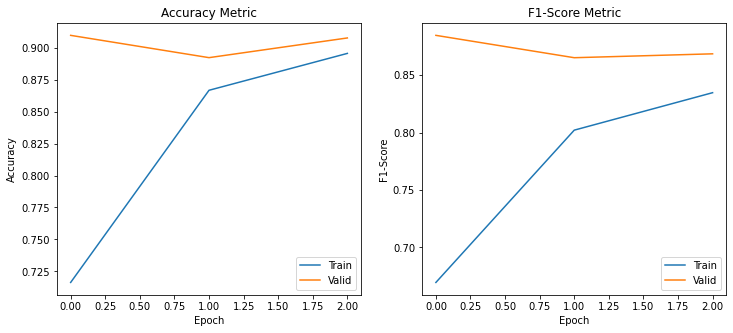

 - Training Fine Tuning...
Epoch 1/5
188/188 [==============================] - 26s 99ms/step - loss: 0.3200 - accuracy: 0.8622 - macro_f1: 0.7974 - val_loss: 0.2335 - val_accuracy: 0.9061 - val_macro_f1: 0.8536
Epoch 2/5
188/188 [==============================] - 18s 93ms/step - loss: 0.2053 - accuracy: 0.9160 - macro_f1: 0.8457 - val_loss: 0.1887 - val_accuracy: 0.9271 - val_macro_f1: 0.8718
Epoch 3/5
188/188 [==============================] - 17s 90ms/step - loss: 0.1742 - accuracy: 0.9299 - macro_f1: 0.8618 - val_loss: 0.2302 - val_accuracy: 0.9154 - val_macro_f1: 0.8695
Epoch 4/5
188/188 [==============================] - 17s 91ms/step - loss: 0.1305 - accuracy: 0.9492 - macro_f1: 0.8889 - val_loss: 0.1788 - val_accuracy: 0.9352 - val_macro_f1: 0.8973
Epoch 5/5
188/188 [==============================] - 17s 91ms/step - loss: 0.1143 - accuracy: 0.9568 - macro_f1: 0.8986 - val_loss: 0.1732 - val_accuracy: 0.9433 - val_macro_f1: 0.9020


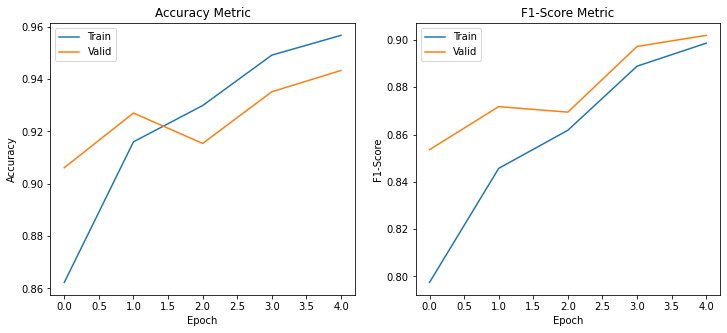

F1 Scores: {'N': 0.953170731707317, 'P': 0.9751716851558373, 'T': 0.8323959505061868}
Acc Scores: {'N': 0.9430501930501931, 'P': 0.9736286919831224, 'T': 0.8788598574821853}



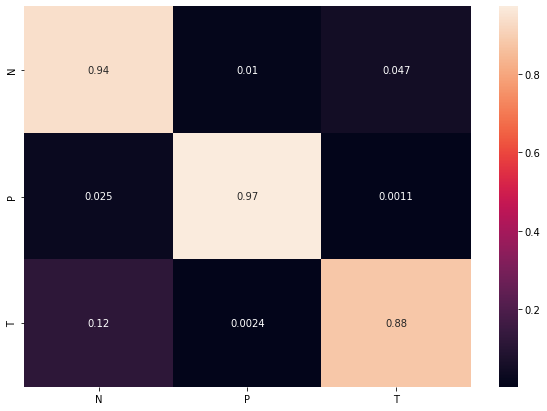

	 Head size: 2 ; Unfrozen Layer: 10 || Training for Fold 2
 - Training Classification Head...
Epoch 1/7
190/190 [==============================] - 26s 105ms/step - loss: 0.5413 - accuracy: 0.7293 - macro_f1: 0.6894 - val_loss: 0.2556 - val_accuracy: 0.9153 - val_macro_f1: 0.8578
Epoch 2/7
190/190 [==============================] - 17s 89ms/step - loss: 0.3071 - accuracy: 0.8676 - macro_f1: 0.8057 - val_loss: 0.2550 - val_accuracy: 0.9009 - val_macro_f1: 0.8598
Epoch 3/7
190/190 [==============================] - 17s 90ms/step - loss: 0.2418 - accuracy: 0.8969 - macro_f1: 0.8372 - val_loss: 0.1976 - val_accuracy: 0.9327 - val_macro_f1: 0.8876
Epoch 4/7
190/190 [==============================] - 17s 90ms/step - loss: 0.2016 - accuracy: 0.9187 - macro_f1: 0.8579 - val_loss: 0.1858 - val_accuracy: 0.9384 - val_macro_f1: 0.9168
Epoch 5/7
190/190 [==============================] - 17s 89ms/step - loss: 0.1685 - accuracy: 0.9323 - macro_f1: 0.8759 - val_loss: 0.1856 - val_accuracy: 0.9342 - v

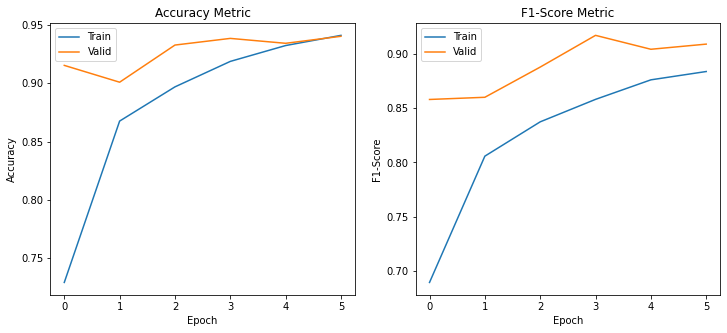

 - Training Fine Tuning...
Epoch 1/5
190/190 [==============================] - 25s 100ms/step - loss: 0.2047 - accuracy: 0.9147 - macro_f1: 0.8585 - val_loss: 0.1642 - val_accuracy: 0.9447 - val_macro_f1: 0.9272
Epoch 2/5
190/190 [==============================] - 17s 89ms/step - loss: 0.1614 - accuracy: 0.9363 - macro_f1: 0.8808 - val_loss: 0.2039 - val_accuracy: 0.9288 - val_macro_f1: 0.9020
Epoch 3/5
190/190 [==============================] - 17s 89ms/step - loss: 0.1407 - accuracy: 0.9442 - macro_f1: 0.8943 - val_loss: 0.1524 - val_accuracy: 0.9471 - val_macro_f1: 0.9239
Epoch 3: early stopping


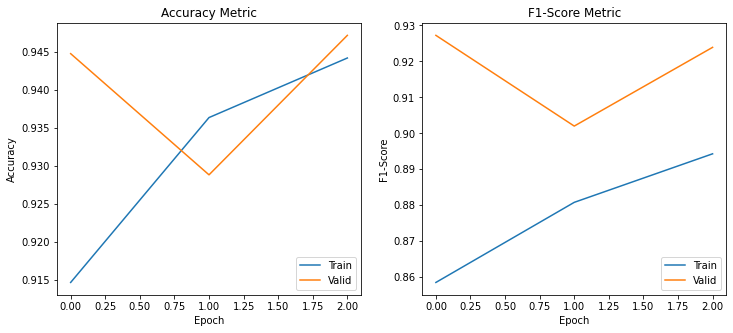

F1 Scores: {'N': 0.956243854473943, 'P': 0.9557522123893805, 'T': 0.8593350383631714}
Acc Scores: {'N': 0.9534313725490197, 'P': 0.968609865470852, 'T': 0.8463476070528967}



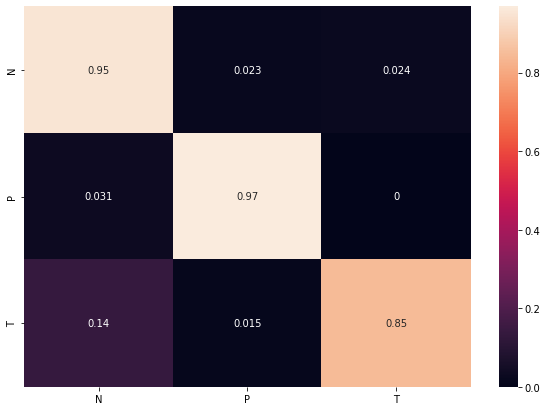

	 Head size: 2 ; Unfrozen Layer: 10 || Training for Fold 3
 - Training Classification Head...
Epoch 1/7
193/193 [==============================] - 26s 103ms/step - loss: 0.5506 - accuracy: 0.7274 - macro_f1: 0.7066 - val_loss: 0.2349 - val_accuracy: 0.9137 - val_macro_f1: 0.8845
Epoch 2/7
193/193 [==============================] - 17s 89ms/step - loss: 0.3066 - accuracy: 0.8662 - macro_f1: 0.8190 - val_loss: 0.2132 - val_accuracy: 0.9201 - val_macro_f1: 0.8908
Epoch 3/7
193/193 [==============================] - 17s 88ms/step - loss: 0.2387 - accuracy: 0.8964 - macro_f1: 0.8464 - val_loss: 0.1699 - val_accuracy: 0.9395 - val_macro_f1: 0.9103
Epoch 4/7
193/193 [==============================] - 17s 87ms/step - loss: 0.1969 - accuracy: 0.9199 - macro_f1: 0.8688 - val_loss: 0.1489 - val_accuracy: 0.9465 - val_macro_f1: 0.9094
Epoch 5/7
193/193 [==============================] - 17s 88ms/step - loss: 0.1686 - accuracy: 0.9299 - macro_f1: 0.8815 - val_loss: 0.1535 - val_accuracy: 0.9408 - v

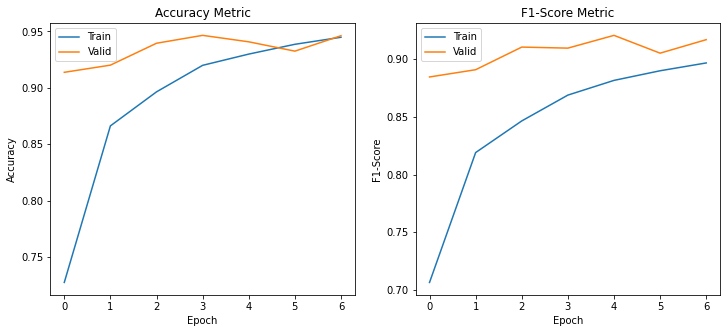

 - Training Fine Tuning...
Epoch 1/5
193/193 [==============================] - 26s 99ms/step - loss: 0.1897 - accuracy: 0.9216 - macro_f1: 0.8773 - val_loss: 0.1899 - val_accuracy: 0.9373 - val_macro_f1: 0.9191
Epoch 2/5
193/193 [==============================] - 17s 88ms/step - loss: 0.1512 - accuracy: 0.9376 - macro_f1: 0.8901 - val_loss: 0.1553 - val_accuracy: 0.9433 - val_macro_f1: 0.9142
Epoch 3/5
193/193 [==============================] - 17s 90ms/step - loss: 0.1151 - accuracy: 0.9535 - macro_f1: 0.9036 - val_loss: 0.1344 - val_accuracy: 0.9504 - val_macro_f1: 0.9309
Epoch 4/5
193/193 [==============================] - 17s 88ms/step - loss: 0.1033 - accuracy: 0.9575 - macro_f1: 0.9141 - val_loss: 0.1317 - val_accuracy: 0.9570 - val_macro_f1: 0.9371
Epoch 5/5
193/193 [==============================] - 17s 88ms/step - loss: 0.0879 - accuracy: 0.9639 - macro_f1: 0.9216 - val_loss: 0.1324 - val_accuracy: 0.9561 - val_macro_f1: 0.9315


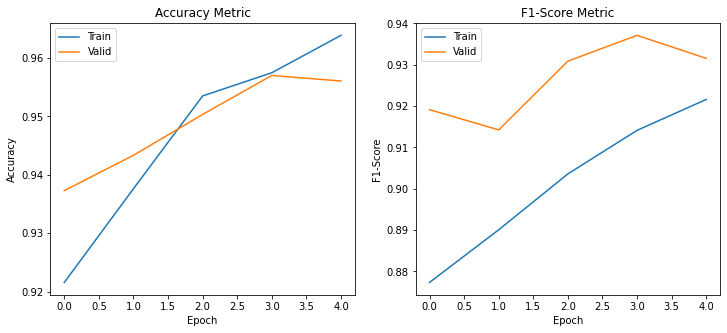

F1 Scores: {'N': 0.9637661994181435, 'P': 0.9752446747265401, 'T': 0.8746736292428199}
Acc Scores: {'N': 0.9619852164730729, 'P': 0.9691075514874142, 'T': 0.8957219251336899}



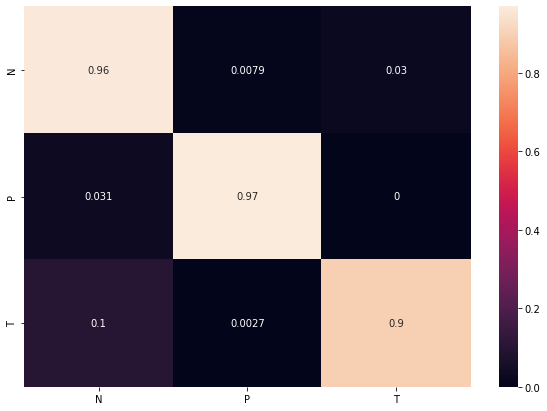

	 Head size: 2 ; Unfrozen Layer: 10 || Training for Fold 4
 - Training Classification Head...
Epoch 1/7
196/196 [==============================] - 27s 103ms/step - loss: 0.5597 - accuracy: 0.7318 - macro_f1: 0.7017 - val_loss: 0.2361 - val_accuracy: 0.9179 - val_macro_f1: 0.8819
Epoch 2/7
196/196 [==============================] - 17s 86ms/step - loss: 0.3064 - accuracy: 0.8673 - macro_f1: 0.8077 - val_loss: 0.2060 - val_accuracy: 0.9274 - val_macro_f1: 0.8673
Epoch 3/7
196/196 [==============================] - 17s 87ms/step - loss: 0.2384 - accuracy: 0.9037 - macro_f1: 0.8394 - val_loss: 0.1730 - val_accuracy: 0.9390 - val_macro_f1: 0.8852
Epoch 4/7
196/196 [==============================] - 17s 86ms/step - loss: 0.2075 - accuracy: 0.9186 - macro_f1: 0.8582 - val_loss: 0.2019 - val_accuracy: 0.9155 - val_macro_f1: 0.8643
Epoch 5/7
196/196 [==============================] - 17s 87ms/step - loss: 0.1755 - accuracy: 0.9286 - macro_f1: 0.8663 - val_loss: 0.1454 - val_accuracy: 0.9499 - v

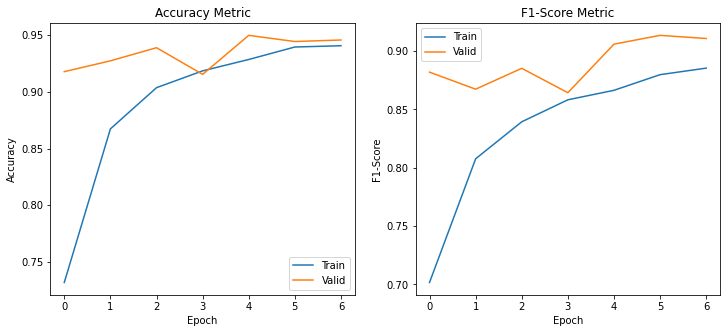

 - Training Fine Tuning...
Epoch 1/5
196/196 [==============================] - 25s 97ms/step - loss: 0.1605 - accuracy: 0.9349 - macro_f1: 0.8789 - val_loss: 0.1372 - val_accuracy: 0.9489 - val_macro_f1: 0.9126
Epoch 2/5
196/196 [==============================] - 17s 87ms/step - loss: 0.1370 - accuracy: 0.9480 - macro_f1: 0.8880 - val_loss: 0.1387 - val_accuracy: 0.9506 - val_macro_f1: 0.9187
Epoch 3/5
196/196 [==============================] - 17s 88ms/step - loss: 0.1076 - accuracy: 0.9582 - macro_f1: 0.8985 - val_loss: 0.1296 - val_accuracy: 0.9513 - val_macro_f1: 0.9242
Epoch 4/5
196/196 [==============================] - 17s 87ms/step - loss: 0.1058 - accuracy: 0.9598 - macro_f1: 0.9008 - val_loss: 0.1608 - val_accuracy: 0.9451 - val_macro_f1: 0.9122
Epoch 5/5
196/196 [==============================] - 17s 87ms/step - loss: 0.1032 - accuracy: 0.9584 - macro_f1: 0.9024 - val_loss: 0.1432 - val_accuracy: 0.9479 - val_macro_f1: 0.9111
Epoch 5: early stopping


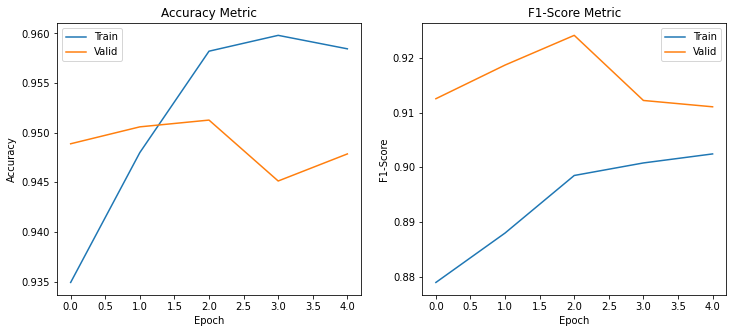

F1 Scores: {'N': 0.9590844062947068, 'P': 0.9751966122202057, 'T': 0.8583333333333334}
Acc Scores: {'N': 0.9544419134396356, 'P': 0.9817295980511571, 'T': 0.865546218487395}



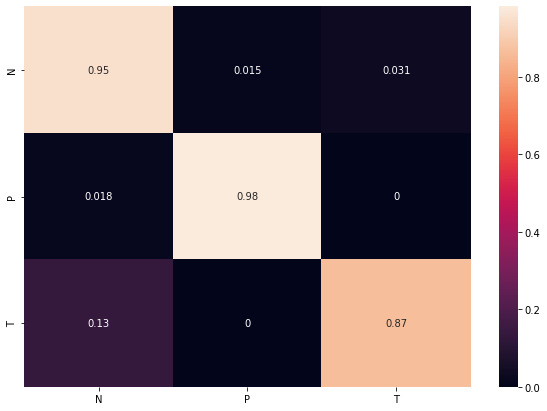

	 Head size: 2 ; Unfrozen Layer: 10 || Training for Fold 5
 - Training Classification Head...
Epoch 1/7
201/201 [==============================] - 26s 97ms/step - loss: 0.5149 - accuracy: 0.7627 - macro_f1: 0.7116 - val_loss: 0.2314 - val_accuracy: 0.9200 - val_macro_f1: 0.8888
Epoch 2/7
201/201 [==============================] - 17s 86ms/step - loss: 0.2888 - accuracy: 0.8818 - macro_f1: 0.8247 - val_loss: 0.1967 - val_accuracy: 0.9310 - val_macro_f1: 0.9089
Epoch 3/7
201/201 [==============================] - 17s 85ms/step - loss: 0.2285 - accuracy: 0.9078 - macro_f1: 0.8596 - val_loss: 0.1849 - val_accuracy: 0.9310 - val_macro_f1: 0.9181
Epoch 4/7
201/201 [==============================] - 17s 84ms/step - loss: 0.1838 - accuracy: 0.9249 - macro_f1: 0.8814 - val_loss: 0.1716 - val_accuracy: 0.9394 - val_macro_f1: 0.9213
Epoch 5/7
201/201 [==============================] - 17s 85ms/step - loss: 0.1649 - accuracy: 0.9332 - macro_f1: 0.8943 - val_loss: 0.2083 - val_accuracy: 0.9276 - va

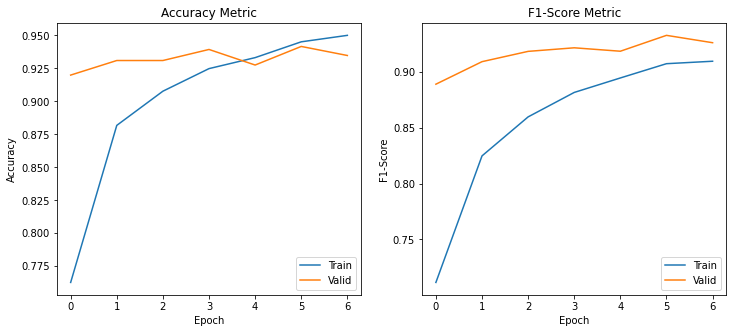

 - Training Fine Tuning...
Epoch 1/5
201/201 [==============================] - 25s 95ms/step - loss: 0.1450 - accuracy: 0.9436 - macro_f1: 0.9034 - val_loss: 0.1675 - val_accuracy: 0.9405 - val_macro_f1: 0.9248
Epoch 2/5
201/201 [==============================] - 17s 86ms/step - loss: 0.1242 - accuracy: 0.9505 - macro_f1: 0.9102 - val_loss: 0.1601 - val_accuracy: 0.9447 - val_macro_f1: 0.9287
Epoch 3/5
201/201 [==============================] - 17s 85ms/step - loss: 0.1064 - accuracy: 0.9553 - macro_f1: 0.9188 - val_loss: 0.1768 - val_accuracy: 0.9367 - val_macro_f1: 0.9172
Epoch 4/5
201/201 [==============================] - 17s 86ms/step - loss: 0.1003 - accuracy: 0.9608 - macro_f1: 0.9184 - val_loss: 0.1617 - val_accuracy: 0.9497 - val_macro_f1: 0.9343
Epoch 5/5
201/201 [==============================] - 17s 85ms/step - loss: 0.0967 - accuracy: 0.9632 - macro_f1: 0.9221 - val_loss: 0.1610 - val_accuracy: 0.9428 - val_macro_f1: 0.9199


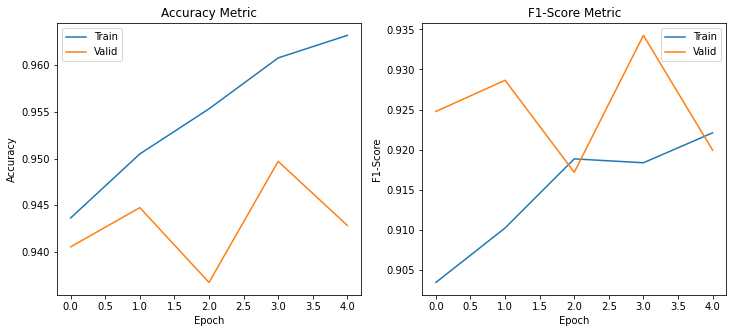

F1 Scores: {'N': 0.954388172381252, 'P': 0.9682875264270614, 'T': 0.8307692307692308}
Acc Scores: {'N': 0.9528894472361809, 'P': 0.9608391608391609, 'T': 0.8517350157728707}



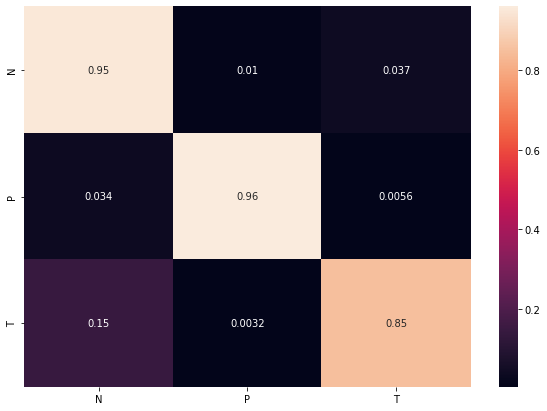

{'f1_N': 0.9573306728550725,
 'f1_P': 0.9699305421838049,
 'f1_T': 0.8511014364429483,
 'acc_N': 0.9531596285496204,
 'acc_P': 0.9707829735663414,
 'acc_T': 0.8676421247858077,
 'best_epoch_head': 4.4,
 'best_epoch_fine': 3.4}

In [13]:
from sklearn.model_selection import StratifiedKFold
from itertools import product

LOSS_FUNCT_TO_USE = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
METRICS_TO_TRACK = [ 'accuracy', macro_f1 ]

## TRAINING PARAMS
BATCH_SIZE = 64

## TRAINING PHASES
EPOCHS_HEAD_TRAINING = 7
EPOCHS_FINE_TUNING = 5

## MODEL PARAMS
HEAD_SIZES = 2
UNFROZEN_LAYERS = 10

## RESULTS
skf = StratifiedKFold(n_splits=5)

training_results = []
for i, (train_idx, valid_idx) in enumerate(skf.split(X_data, Y_data)):
    callback_head = keras.callbacks.EarlyStopping('val_macro_f1', mode='max', restore_best_weights=True, verbose=1, patience=2)
    callback_fine = keras.callbacks.EarlyStopping('val_macro_f1', mode='max', restore_best_weights=True, verbose=1, patience=2)

    print("=" * 100)
    print(f"\t Head size: {HEAD_SIZES} ; Unfrozen Layer: {UNFROZEN_LAYERS} || Training for Fold", i+1)
    print("=" * 100)

    # get the ids and build the datasets
    train_ids, valid_ids = X_data[train_idx], X_data[valid_idx]
    train_ds, valid_ds = define_dataset(train_ids, valid_ids, base_dir=RAW_DATA_DIR)

    # batch data
    train_ds = train_ds.batch(BATCH_SIZE)
    valid_ds = valid_ds.batch(BATCH_SIZE)

    # compute the class_weights in the training data
    Y_train = Y_data[train_idx]
    train_weigths = class_weight.compute_class_weight( 'balanced', classes=CLASS_NAMES, y=Y_train )
    train_weigths_dict = dict(enumerate(train_weigths)) 

    # build the model
    cnn_model = build_cnn_model( HEAD_SIZES, num_classes=3 )

    with tf.device('/device:GPU:0'):

        # Training ---- Part 1: Training Classification Head
        print( " - Training Classification Head..." )
        cnn_model = config_model_for_head_training( cnn_model )
        cnn_model.compile(optimizer='adam', loss=LOSS_FUNCT_TO_USE, metrics=METRICS_TO_TRACK)
    
        history_head = cnn_model.fit(
            train_ds,
            validation_data=valid_ds,
            epochs=EPOCHS_HEAD_TRAINING,
            class_weight=train_weigths_dict,
            callbacks=[callback_head]
        )
        plot_model_training_hist(history_head)
        print("=" * 100)
    
        # Training ---- Part 2: Fine Tuning
        print( " - Training Fine Tuning..." )
        cnn_model = config_model_for_fine_tuning( UNFROZEN_LAYERS, cnn_model )
        cnn_model.compile(optimizer='adam', loss=LOSS_FUNCT_TO_USE, metrics=METRICS_TO_TRACK)
    
        history_fine = cnn_model.fit(
            train_ds,
            validation_data=valid_ds,
            epochs=EPOCHS_FINE_TUNING,
            class_weight=train_weigths_dict,
            callbacks=[callback_fine]
        )

        plot_model_training_hist(history_fine)
        print("=" * 100)

    # get and store the results
    fold_results = evaluate_model(valid_ds, cnn_model)
    fold_best_epoch_head = np.argmax( history_head.history['val_macro_f1'] ) + 1
    fold_best_epoch_fine = np.argmax( history_fine.history['val_macro_f1'] ) + 1
    fold_results['best_epoch_head'] = fold_best_epoch_head
    fold_results['best_epoch_fine'] = fold_best_epoch_fine

    training_results.append(fold_results)
    del cnn_model, callback_head, callback_fine

# calculate the training results
training_results = pd.DataFrame.from_records(training_results)
training_results = training_results.mean(axis=0).to_dict()
training_results

## 05. Training Preprocessed Data:

Training the best parameters with the preprocessed data...

	 Head size: 2 ; Unfrozen Layer: 10 || Training for Fold 1


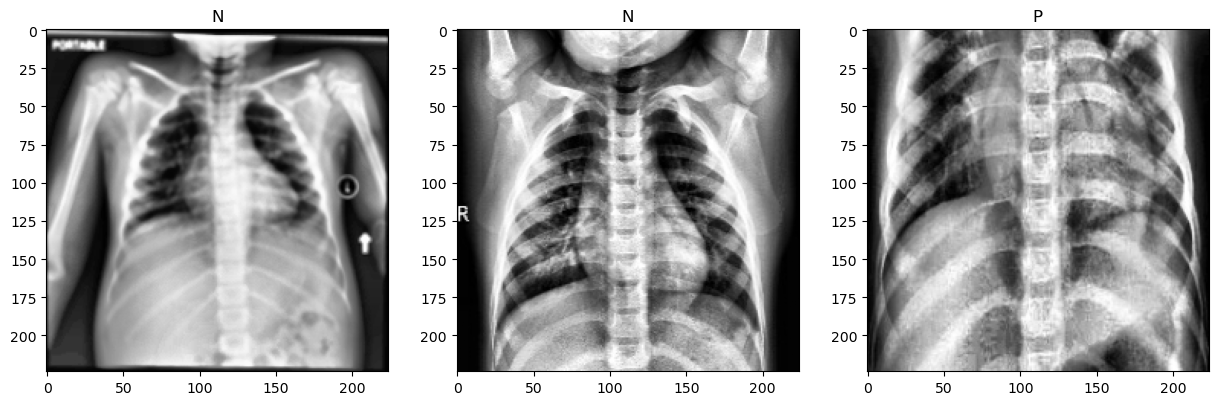

 9420800/29084464 [========>.....................] - ETA: 5s

KeyboardInterrupt: 

In [13]:
from sklearn.model_selection import StratifiedKFold
from itertools import product

LOSS_FUNCT_TO_USE = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
METRICS_TO_TRACK = [ 'accuracy', macro_f1 ]

## TRAINING PARAMS
BATCH_SIZE = 64

## TRAINING PHASES
EPOCHS_HEAD_TRAINING = 7
EPOCHS_FINE_TUNING = 5

## MODEL PARAMS
HEAD_SIZES = 2
UNFROZEN_LAYERS = 10

## RESULTS
skf = StratifiedKFold(n_splits=5)

training_results = []
for i, (train_idx, valid_idx) in enumerate(skf.split(X_data, Y_data)):
    callback_head = keras.callbacks.EarlyStopping('val_macro_f1', mode='max', restore_best_weights=True, verbose=1, patience=2)
    callback_fine = keras.callbacks.EarlyStopping('val_macro_f1', mode='max', restore_best_weights=True, verbose=1, patience=2)

    print("=" * 100)
    print(f"\t Head size: {HEAD_SIZES} ; Unfrozen Layer: {UNFROZEN_LAYERS} || Training for Fold", i+1)
    print("=" * 100)

    # get the ids and build the datasets
    train_ids, valid_ids = X_data[train_idx], X_data[valid_idx]
    train_ds, valid_ds = define_dataset(train_ids, valid_ids, base_dir=SUBSET_DATA_DIR)
    visualize_data_samples( train_ds )

    # batch data
    train_ds = train_ds.batch(BATCH_SIZE)
    valid_ds = valid_ds.batch(BATCH_SIZE)

    # compute the class_weights in the training data
    Y_train = Y_data[train_idx]
    train_weigths = class_weight.compute_class_weight( 'balanced', classes=CLASS_NAMES, y=Y_train )
    train_weigths_dict = dict(enumerate(train_weigths)) 

    # build the model
    cnn_model = build_cnn_model( HEAD_SIZES, num_classes=3 )

    with tf.device('/device:GPU:0'):

        # Training ---- Part 1: Training Classification Head
        print( " - Training Classification Head..." )
        cnn_model = config_model_for_head_training( cnn_model )
        cnn_model.compile(optimizer='adam', loss=LOSS_FUNCT_TO_USE, metrics=METRICS_TO_TRACK)
    
        history_head = cnn_model.fit(
            train_ds,
            validation_data=valid_ds,
            epochs=EPOCHS_HEAD_TRAINING,
            class_weight=train_weigths_dict,
            callbacks=[callback_head]
        )
        plot_model_training_hist(history_head)
        print("=" * 100)
    
        # Training ---- Part 2: Fine Tuning
        print( " - Training Fine Tuning..." )
        cnn_model = config_model_for_fine_tuning( UNFROZEN_LAYERS, cnn_model )
        cnn_model.compile(optimizer='adam', loss=LOSS_FUNCT_TO_USE, metrics=METRICS_TO_TRACK)
    
        history_fine = cnn_model.fit(
            train_ds,
            validation_data=valid_ds,
            epochs=EPOCHS_FINE_TUNING,
            class_weight=train_weigths_dict,
            callbacks=[callback_fine]
        )

        plot_model_training_hist(history_fine)
        print("=" * 100)

    # get and store the results
    fold_results = evaluate_model(valid_ds, cnn_model)
    fold_best_epoch_head = np.argmax( history_head.history['val_macro_f1'] ) + 1
    fold_best_epoch_fine = np.argmax( history_fine.history['val_macro_f1'] ) + 1
    fold_results['best_epoch_head'] = fold_best_epoch_head
    fold_results['best_epoch_fine'] = fold_best_epoch_fine

    training_results.append(fold_results)
    del cnn_model, callback_head, callback_fine

# calculate the training results
training_results = pd.DataFrame.from_records(training_results)
training_results = training_results.mean(axis=0).to_dict()
training_results

# 06. Training model on the entire Dataset:

From the stored model the prediction on the testing data can be done.

In [ ]:
LOSS_FUNCT_TO_USE = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
METRICS_TO_TRACK = [ 'accuracy', macro_f1 ]

## TRAINING PARAMS
BATCH_SIZE = 64

## TRAINING PHASES
EPOCHS_HEAD_TRAINING = 7
EPOCHS_FINE_TUNING = 5

## MODEL PARAMS
HEAD_SIZES = 2
UNFROZEN_LAYERS = 10

## RESULTS
print("=" * 100)
print(f"\t Head size: {HEAD_SIZES} ; Unfrozen Layer: {UNFROZEN_LAYERS}")
print("=" * 100)

# get the ids and build the datasets
train_ids = X_data
train_ds = define_train_dataset(train_ids, base_dir=RAW_DATA_DIR)

# batch data
train_ds = train_ds.batch(BATCH_SIZE)

# compute the class_weights in the training data
Y_train = Y_data
train_weigths = class_weight.compute_class_weight( 'balanced', classes=CLASS_NAMES, y=Y_train )
train_weigths_dict = dict(enumerate(train_weigths)) 

# build the model
cnn_model = build_cnn_model( HEAD_SIZES, num_classes=3 )

with tf.device('/device:GPU:0'):

    # Training ---- Part 1: Training Classification Head
    print( " - Training Classification Head..." )
    cnn_model = config_model_for_head_training( cnn_model )
    cnn_model.compile(optimizer='adam', loss=LOSS_FUNCT_TO_USE, metrics=METRICS_TO_TRACK)
    
    history_head = cnn_model.fit(
        train_ds,
        epochs=EPOCHS_HEAD_TRAINING,
        class_weight=train_weigths_dict,
    )
    print("=" * 100)
    
    # Training ---- Part 2: Fine Tuning
    print( " - Training Fine Tuning..." )
    cnn_model = config_model_for_fine_tuning( UNFROZEN_LAYERS, cnn_model )
    cnn_model.compile(optimizer='adam', loss=LOSS_FUNCT_TO_USE, metrics=METRICS_TO_TRACK)
    
    history_fine = cnn_model.fit(
        train_ds,
        epochs=EPOCHS_FINE_TUNING,
        class_weight=train_weigths_dict,
    )

    print("=" * 100)

Store the final model:

In [17]:
cnn_model.save( os.path.join(RESULTS_DIR, 'best_model.h5'))